# Nutrition Tracker Survival Analysis
by: Andy Luc

## Business case:
Health and fitness has always been a topic of interest to me and I am fairly active when it comes to staying in shape. Part of that journey involves the consistency of tracking nutritional intake. One of the most popular apps today is MyFitnessPal, which tracks this on a daily basis.

Based on only user inputs of daily food intake and a target goal:
1. Can we predict when or if a user decides to churn or quit using the app?

2. Is there a certain nutritional item that contributes to a user quitting the platform?


### Pickled files:
Save processing time when loading into a dataframe.

- final_churn.pkl
- df.pkl
- nutri_per_day.pkl

In [26]:
import pandas as pd
import numpy as np
from datetime import date, datetime
from lifelines import CoxPHFitter, KaplanMeierFitter
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from functions import (json, pandas, daily_totals, daily_goals, merge, 
                       parsed_dict, end_date_col, find_date)
plt.style.use('seaborn')
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Exploratory Data Analysis

In [ ]:
# Reading the data file
raw_data = pd.read_csv('data/mfp-diaries.tsv',
                  sep='\t',
                  header=None,
                  names=['userid','diary_date','food_entries','daily_goal'])

In [ ]:
raw_data.head()

In [ ]:
# Number of unique users
len(raw_data['userid'].unique())

### Setting up dataframe for Survival Analysis
Since we are concerned with when a user decides to stop using the MyFitnessPal program based on their input attributes, I am going to focus on the *diary_date* and *daily_goal* columns. First, we need to parse the nested dictionary within the daily_goal column.

In [ ]:
# Parsing only the dialy_goals column
d_goal = raw_data.drop(['userid', 'diary_date','food_entries'], axis=1)

In [ ]:
d_goal.head()

In [ ]:
# Loading into json format for extraction
data = json.loads(d_goal['daily_goal'][0])
data

### Create 1 column per dictionary in both total key and goal key

- total
    + total_calories
    + total_carbs
    + total_fat
    + total_fiber
    + total_protein
    + total_sodium
    + total_sugar
- goal
    + goal_calories
    + goal_carbs
    + goal_fat
    + goal_fiber
    + goal_protein
    + goal_sodium
    + goal_sugar

In [ ]:
total_dict = daily_totals(data)

goal_dict = daily_goals(data)

merge(total_dict, goal_dict)

full_list = parsed_dict(d_goal, data)

In [ ]:
# Putting it back into a pandas dataframe
full_df = pd.DataFrame(full_list)
full_df.head()

In [ ]:
# Merging the original dataframe with the newly parsed daily_goal column
conn = pd.concat([raw_data, full_df], axis=1)

In [ ]:
# Looking at the number of null values for each column
conn.isna().sum()

In [ ]:
# Dropping columns which have high null values which are not beneficial to the features being used
clean_df = conn.drop(['food_entries','daily_goal','goal_calcium','goal_chol',
                       'goal_iron','goal_mon fat','goal_ply fat','goal_potass.',
                       'goal_sat fat','goal_trn fat','goal_vit a','goal_vit c',
                       'total_calcium','total_chol','total_iron','total_mon fat',
                       'total_ply fat','total_potass.','total_sat fat','total_trn fat',
                       'total_vit a','total_vit c'], axis=1)

In [ ]:
# Fill the remaining null values of each nutrient with 0
clean_df.fillna(0, inplace=True)

In [ ]:
# Changing diary_date column to a datetime type
clean_df['diary_date'] = pd.to_datetime(clean_df['diary_date'])

In [ ]:
clean_df.head()

Add additional columns:
- **total_sum**: Total sum of input values for the day
- **goal_sum**: Total sum of goal values for the day
- **achievement**: Indicates whether or not a user has met their daily goal within a tolerance of 10%.
    - 1 = Succeed
    - 0 = Fail

In [ ]:
nutrients = ['calories','carbs','fat','fiber','protein','sodium','sugar']

total_s = []
goal_s = []
for nutrient in nutrients:
    total_s.append(f'total_{nutrient}')
    goal_s.append(f'goal_{nutrient}')

clean_df['total_sum'] = clean_df[total_s].apply(np.sum, axis=1)

clean_df['goal_sum'] = clean_df[goal_s].apply(np.sum, axis=1)

clean_df['achievement'] = np.where(abs((clean_df['total_sum'] - 
                                          clean_df['goal_sum']) / 
                                          clean_df['goal_sum']) <= 0.1, 1, 0)

### Create Multi-Collinearity Heatmap
This is just to show if any columns have collinear values. We would essentially drop a certain column if the value they are highly correlated, but in this case we want to keep the features as they may pertain to the survival analysis model. As you can see sugar and carbs are correlated, which we can say is a true statement.

In [ ]:
coll = clean_df.drop(['userid','diary_date','goal_calories','goal_carbs',
                        'goal_fat','goal_fiber','goal_protein','goal_sodium',
                        'goal_sugar','total_sum','goal_sum'], axis=1)

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(coll.corr(), center=0, cmap='BrBG', annot=True)

ax.set_title('Multi-Collinearity of Attributes')

## Survival Analysis
Min & Max Diary Dates: Sept 14, 2014 - Apr 9, 2015
1. duration_col = length of time between start date and time of churn
2. event_col = time of churn (when there is a break >=5 days)
    * churn = 1
    * continuous = 0

In [ ]:
# Creates a new column with the previous date of the diary_date column
end_date_col(clean_df)

In [23]:
clean_df = pd.read_pickle('pkl/end_date.pkl')

In [24]:
clean_df.head()

,userid,diary_date,goal_calories,goal_carbs,goal_fat,goal_fiber,goal_protein,goal_sodium,goal_sugar,total_calories,total_carbs,total_fat,total_fiber,total_protein,total_sodium,total_sugar,total_sum,goal_sum,achievement,end_date
0,1,2014-09-14,3173.0,396.0,105.0,0.0,160.0,2300.0,119.0,2924.0,340.0,114.0,0.0,186.0,3658.0,109.0,7331.0,6253.0,0,2014-09-15
1,1,2014-09-15,1572.0,196.0,52.0,0.0,79.0,2300.0,59.0,2430.0,96.0,37.0,0.0,50.0,855.0,63.0,3531.0,4258.0,0,2014-09-16
2,1,2014-09-16,1832.0,229.0,61.0,0.0,92.0,2300.0,69.0,1862.0,158.0,54.0,0.0,114.0,2215.0,100.0,4503.0,4583.0,1,2014-09-17
3,1,2014-09-17,1685.0,210.0,56.0,0.0,85.0,2300.0,63.0,2251.0,187.0,60.0,0.0,98.0,1765.0,105.0,4466.0,4399.0,1,2014-09-18
4,1,2014-09-18,1597.0,199.0,53.0,0.0,80.0,2300.0,60.0,2001.0,113.0,81.0,0.0,202.0,1101.0,71.0,3569.0,4289.0,0,2014-09-19


In [25]:
clean_df.loc[0, 'end_date'] - clean_df.loc[0, 'diary_date']

Timedelta('1 days 00:00:00')

Using the function **find_date**, we can setup a dataframe with the start date and when they churn for all userid's. If they have not churned, NaT is there to indicate "Not a Time."

In [27]:
date = pd.DataFrame(find_date(clean_df))
date.head()

,churn_date,start_date,userid
0,2014-11-01,2014-09-14,1
1,NaT,2015-01-12,2
2,2014-09-23,2014-09-14,3
3,2014-10-22,2014-10-21,4
4,NaT,2014-09-14,5


In [28]:
date['days'] = (date['churn_date'] - date['start_date']).dt.days
date.head()

,churn_date,start_date,userid,days
0,2014-11-01,2014-09-14,1,48.0
1,NaT,2015-01-12,2,NaN
2,2014-09-23,2014-09-14,3,9.0
3,2014-10-22,2014-10-21,4,1.0
4,NaT,2014-09-14,5,NaN


In [12]:
date['churn_5days'] = date['churn_date'].apply(lambda x: 0 if type(x) is not pd.Timestamp else 1)
date.head()

,churn_date,start_date,userid,days,churn_5days
0,2014-11-01,2014-09-14,1,48.0,1
1,NaT,2015-01-12,2,NaN,0
2,2014-09-23,2014-09-14,3,9.0,1
3,2014-10-22,2014-10-21,4,1.0,1
4,NaT,2014-09-14,5,NaN,0


In [13]:
days_count = clean_df['userid'].value_counts().sort_index()
days_count = pd.DataFrame(days_count).rename(columns={'userid': 'days_count'})
days_count.head()

,days_count
1,174
2,60
3,7
4,27
5,179


In [14]:
churn = pd.merge(days_count, date, left_index=True, right_on='userid')
churn.index = churn['userid']
churn = churn.drop('userid', axis=1)

In [15]:
churn.head()

,days_count,churn_date,start_date,days,churn_5days
userid,,,,,
1,174,2014-11-01,2014-09-14,48.0,1
2,60,NaT,2015-01-12,NaN,0
3,7,2014-09-23,2014-09-14,9.0,1
4,27,2014-10-22,2014-10-21,1.0,1
5,179,NaT,2014-09-14,NaN,0


In [16]:
churn.days.fillna(churn.days_count, inplace=True)
churn.head()

,days_count,churn_date,start_date,days,churn_5days
userid,,,,,
1,174,2014-11-01,2014-09-14,48.0,1
2,60,NaT,2015-01-12,60.0,0
3,7,2014-09-23,2014-09-14,9.0,1
4,27,2014-10-22,2014-10-21,1.0,1
5,179,NaT,2014-09-14,179.0,0


### Exploratory Analysis with churn dataframe

In [17]:
user = clean_df[clean_df['userid'] == 3]

print(user.diary_date.diff().value_counts())
print('\n')
print(user.diary_date.value_counts().sum())

user[user.diary_date.diff() > pd.Timedelta(3, 'D')]

1 days    5
4 days    1
Name: diary_date, dtype: int64


7


,userid,diary_date,goal_calories,goal_carbs,goal_fat,goal_fiber,goal_protein,goal_sodium,goal_sugar,total_calories,total_carbs,total_fat,total_fiber,total_protein,total_sodium,total_sugar,total_sum,goal_sum,achievement,end_date
240,3,2014-09-23,1210.0,151.0,40.0,25.0,60.0,2300.0,0.0,1208.0,173.0,30.0,11.0,34.0,1707.0,0.0,3163.0,3786.0,0,2014-10-21


In [18]:
# Merging "final_churn" and "total_goal" dataframes
cols = clean_df.drop(['userid','diary_date'], axis=1).columns

condense = clean_df.groupby(['userid'])[cols].sum()

svl = pd.merge(churn, condense, left_index=True, right_index=True)

In [19]:
# Creates 7 new columns calculating whether or not a user has reached within 10% of their goal,
# for the duration of the time using the app
nutrients = ['calories','carbs','fat','fiber','protein','sodium','sugar']

for nutrient in nutrients:
    total = svl[f'total_{nutrient}']
    goal = svl[f'goal_{nutrient}']
    svl[f'{nutrient}_10_pct'] = np.where(abs((total - goal) / goal) <= 0.1, 1, 0)

In [20]:
svl.head()

,days_count,churn_date,start_date,days,churn_5days,goal_calories,goal_carbs,goal_fat,goal_fiber,goal_protein,...,total_sum,goal_sum,achievement,calories_10_pct,carbs_10_pct,fat_10_pct,fiber_10_pct,protein_10_pct,sodium_10_pct,sugar_10_pct
userid,,,,,,,,,,,,,,,,,,,,,
1,174,2014-11-01,2014-09-14,48.0,1,375085.0,46633.0,12472.0,0.0,19029.0,...,844699.0,867495.0,68,1,0,1,0,0,1,1
2,60,NaT,2015-01-12,60.0,0,90925.0,11387.0,2955.0,0.0,4714.0,...,208179.0,251403.0,11,1,1,0,0,0,0,0
3,7,2014-09-23,2014-09-14,9.0,1,9438.0,1178.0,312.0,196.0,469.0,...,23646.0,27693.0,2,0,0,0,0,0,0,0
4,27,2014-10-22,2014-10-21,1.0,1,44211.0,5524.0,1464.0,0.0,2223.0,...,69533.0,115522.0,4,0,0,0,0,0,0,0
5,179,NaT,2014-09-14,179.0,0,572414.0,0.0,15948.0,7564.0,35677.0,...,970881.0,1064788.0,58,1,0,0,0,1,0,1


In [21]:
svl.drop(svl.columns.difference(['days','churn_5days','achievement','calories_10_pct',
                                          'carbs_10_pct','fat_10_pct','fiber_10_pct','protein_10_pct',
                                          'sodium_10_pct','sugar_10_pct']), 1, inplace=True)

In [22]:
svl.head()

,days,churn_5days,achievement,calories_10_pct,carbs_10_pct,fat_10_pct,fiber_10_pct,protein_10_pct,sodium_10_pct,sugar_10_pct
userid,,,,,,,,,,
1,48.0,1,68,1,0,1,0,0,1,1
2,60.0,0,11,1,1,0,0,0,0,0
3,9.0,1,2,0,0,0,0,0,0,0
4,1.0,1,4,0,0,0,0,0,0,0
5,179.0,0,58,1,0,0,0,1,0,1


### 5 day Churn:

In [23]:
cph = CoxPHFitter()
five = cph.fit(svl, duration_col='days', event_col='churn_5days')
five.print_summary()

<lifelines.CoxPHFitter: fitted with 9896 observations, 2789 censored>
      duration col = 'days'
         event col = 'churn_5days'
number of subjects = 9896
  number of events = 7107
partial log-likelihood = -58751.44
  time fit was run = 2019-07-08 04:42:41 UTC

---
                 coef exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
achievement     -0.04      0.96      0.00 -36.46 <0.005    964.51       -0.04       -0.03
calories_10_pct -0.02      0.98      0.04  -0.51   0.61      0.71       -0.09        0.05
carbs_10_pct     0.06      1.07      0.04   1.68   0.09      3.42       -0.01        0.14
fat_10_pct       0.13      1.14      0.03   4.18 <0.005     15.07        0.07        0.19
fiber_10_pct     0.15      1.16      0.08   1.91   0.06      4.17       -0.00        0.31
protein_10_pct  -0.13      0.88      0.05  -2.79   0.01      7.56       -0.22       -0.04
sodium_10_pct    0.10      1.11      0.04   2.56   0.01      6.59        0.02        0.18
sugar_10_p

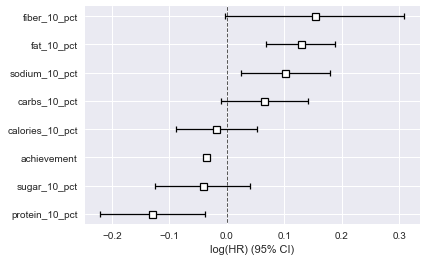

In [24]:
five.plot()

Text(0.5, 1.0, 'Survival Analysis for Single Attribute')

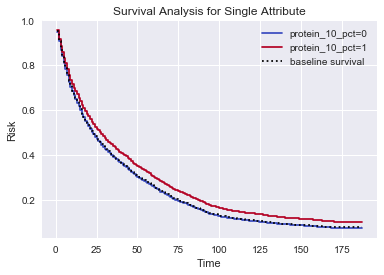

In [25]:
cph.plot_covariate_groups('protein_10_pct', [0, 1], cmap='coolwarm')
plt.xlabel('Time')
plt.ylabel('Risk')
plt.title('Survival Analysis for Single Attribute')

Text(0.5, 1.0, 'Survival Analysis for Single Attribute')

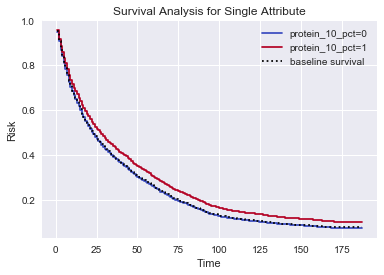

In [26]:
cph.plot_covariate_groups('protein_10_pct', [0, 1], cmap='coolwarm')
plt.xlabel('Time')
plt.ylabel('Risk')
plt.title('Survival Analysis for Single Attribute')

For example: At 25 days, there is a higher risk of churning based only on meeting protein goals. As a result, the company should provide some sort of marketing incentive for users to keep progressing at around the 25 day mark.

## Logistic Regression

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_curve, auc, precision_score, recall_score, accuracy_score,
f1_score, confusion_matrix, classification_report)

In [28]:
#Setting X and y variables, then Train Test Split
X = svl.drop(['churn_5days'], axis=1)
y = svl.churn_5days

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [29]:
loreg = LogisticRegression(solver='lbfgs', max_iter=1000)
loreg.fit(X_train, y_train)
loreg_preds = loreg.predict(X_test)

In [30]:
def print_metrics(y, loreg_preds):
    print("Precision Score: {}".format(precision_score(y, loreg_preds)))
    print("Recall Score: {}".format(recall_score(y, loreg_preds)))
    print("Accuracy Score: {}".format(accuracy_score(y, loreg_preds)))
    print("F1 Score: {}".format(f1_score(y, loreg_preds)))
    
print_metrics(y_test, loreg_preds)

Precision Score: 0.7763888888888889
Recall Score: 0.9469226425748165
Accuracy Score: 0.7667744543249798
F1 Score: 0.8532180106843044


In [31]:
print(classification_report(y_test, loreg_preds))

              precision    recall  f1-score   support

           0       0.70      0.31      0.43       703
           1       0.78      0.95      0.85      1771

   micro avg       0.77      0.77      0.77      2474
   macro avg       0.74      0.63      0.64      2474
weighted avg       0.75      0.77      0.73      2474



In [32]:
X_train.head()

,days,achievement,calories_10_pct,carbs_10_pct,fat_10_pct,fiber_10_pct,protein_10_pct,sodium_10_pct,sugar_10_pct
userid,,,,,,,,,
4883,3.0,4,0,0,0,0,0,0,0
1448,179.0,98,1,0,0,0,0,0,0
4705,37.0,10,0,1,0,0,0,0,0
5601,24.0,32,1,0,1,0,0,1,0
3120,179.0,34,0,1,1,0,0,0,0


In [33]:
m = np.array((50, 1, 0, 1, 0, 0, 0, 0, 0))
m_df = pd.DataFrame(m).T
m_df

,0,1,2,3,4,5,6,7,8
0,50,1,0,1,0,0,0,0,0


In [34]:
loreg.predict(m_df)

array([1])

AUC: 0.7013597448380057


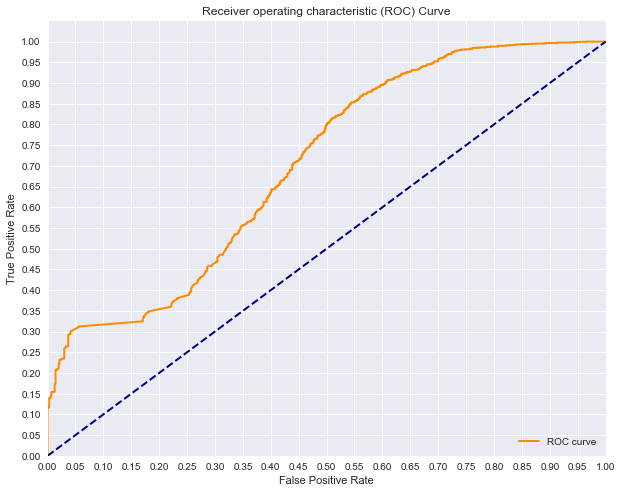

In [35]:
y_score = loreg.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)
print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()